In [16]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats

# Load the shapefile containing city polygons.
cities = gpd.read_file("input/Morphological_Urban_Area_SSP_all.shp")

# Path to your LCZ raster exported from GEE (e.g., a GeoTIFF file).
lcz_raster = "input/lcz_v3.tif"

# Compute zonal statistics for each polygon.
# The 'categorical=True' option returns a dictionary for each polygon with counts per LCZ value.
stats = zonal_stats(cities, lcz_raster, categorical=True)
cities['lcz_stats'] = stats

# Define a function to compute the share of each LCZ type.
def calculate_shares(stat_dict):
    total = sum(stat_dict.values())
    if total == 0:
        return {}
    # Compute the share (fraction) for each LCZ class.
    return {lcz: count / total for lcz, count in stat_dict.items()}

# Apply the function to calculate LCZ shares for each city and store the result in a new column.
cities['lcz_shares'] = cities['lcz_stats'].apply(calculate_shares)

# Rename the column "Aggname" to "City".
cities = cities.rename(columns={"Aggname": "City"})

# Expand the dictionary in 'lcz_shares' into separate columns.
# This will create one column per LCZ class. Here we prefix the columns with "LCZ_".
lcz_shares_df = cities['lcz_shares'].apply(pd.Series).add_prefix("LCZ_")
cities = cities.join(lcz_shares_df)

# Read in the CSV file containing additional temperature development data.
temp_data = pd.read_csv("cities_temp_diff_data_SSP5.csv")



# Merge the temperature data with the cities GeoDataFrame on the "City" column.
merged_data = cities.merge(temp_data, on="City", how="left")

# Display the first few rows of the merged DataFrame.
print(merged_data.head())

# Optionally, export the merged data to CSV (dropping the geometry column if not needed).
merged_data.drop(columns='geometry').to_csv("output/merged_data.csv", index=False)

   OBJECTID  FID_1                            City        Area     X2016  \
0         1    1.0                        Winnipeg  476.219088   765.850   
1         2    2.0                         Calabar  141.186185   487.705   
2         3    3.0                           Anqiu  142.614875   522.101   
3         4    4.0                         Maracay  337.575116  1186.158   
4         6    6.0  Tel Aviv-Yafo (Tel Aviv-Jaffa)  783.070329  3661.189   

   Cntry_C                                 Cntry__     Shape_Leng  \
0    124.0                                  Canada  383225.072805   
1    566.0                                 Nigeria   92047.866192   
2    156.0                                   China   85910.670217   
3    862.0  Venezuela (Bolivarian Republic of)\r\n  124586.331505   
4    376.0                                  Israel  228415.427916   

     Shape_Area        ZS_sum  ...    LCZ_14    LCZ_15    LCZ_16    LCZ_17  \
0  4.762191e+08  6.869692e+05  ...  0.355225  0.00

In [ ]:
import pandas as pd

# --- 1) Read & clean the LCZ→measure mapping from Excel ---
mapping_df = (
    pd.read_excel("adaption/lcz_measures_mapping.xlsx",
                  sheet_name="Sheet1",
                  index_col=0)
      .fillna(0)                                  # blank cells → 0
)
mapping_df.index = mapping_df.index.str.replace("LCZ ", "LCZ_")
mapping_df = mapping_df.astype(int)              # ensure integer weights

print(mapping_df)

# --- 2) Identify your LCZ‑share columns in merged_data ---
lcz_cols = [c for c in merged_data.columns if c.startswith("LCZ_")]

# --- 3) Zero‑fill missing LCZ shares in the city data ---
merged_data[lcz_cols] = merged_data[lcz_cols].fillna(0)

# --- 4) Reindex mapping_df so its rows exactly match those LCZ columns ---
mapping_df = mapping_df.reindex(index=lcz_cols, fill_value=0)

# --- 5) Compute weighted scores via dot product ---
weighted_measures = merged_data[lcz_cols].dot(mapping_df)

# --- 5a) Rename so these are “new” columns and won’t clash ---
weighted_measures = weighted_measures.add_suffix("_score")

# --- 6) Inject those columns directly into merged_data ---
merged_data[weighted_measures.columns] = weighted_measures

# --- 7) Aggregate by continent: sum (total potential) and mean (per‑city) ---
score_cols = weighted_measures.columns.tolist()

continent_sum = (
    merged_data
      .groupby("Continent")[score_cols]
      .sum()
      .reset_index()
      .sort_values(by=score_cols, ascending=False)
)

continent_mean = (
    merged_data
      .groupby("Continent")[score_cols]
      .mean()
      .reset_index()
      .sort_values(by=score_cols, ascending=False)
)

# --- 8) Preview results ---
print("=== City-level weighted scores ===")
print(merged_data[["City"] + score_cols].head(), "\n")

print("=== Continent total potential (sum) ===")
print(continent_sum, "\n")

print("=== Continent average potential per city (mean) ===")
print(continent_mean)




        Optimize Urban Openness  Regulate Densification  \
LCZ_1                         1                       1   
LCZ_2                         1                       1   
LCZ_3                         1                       1   
LCZ_4                         0                       0   
LCZ_8                         0                       0   
LCZ_10                        0                       0   

        Restrict Building Height  Raise Pervious Surface Fraction Ratio  \
LCZ_1                          1                                      1   
LCZ_2                          0                                      1   
LCZ_3                          0                                      1   
LCZ_4                          1                                      0   
LCZ_8                          0                                      1   
LCZ_10                         0                                      0   

        Utilize Reflective Building Materials  \
LCZ_1      

In [18]:
merged_data.drop(columns=[
    'SSP4_2020s', 'SSP4_2025s', 'SSP4_2040s', 'SSP4_2070s', 'SSP4_2100s',
    'SSP5_2020s', 'SSP5_2025s', 'SSP5_2040s', 'SSP5_2070s', 'SSP5_2100s',
    'SSP3_2020s', 'SSP3_2025s', 'SSP3_2040s', 'SSP3_2070s', 'SSP3_2100s',
    'geometry'
]).to_csv('Cities_SSP5_adaption_scores.csv')

In [58]:
import pandas as pd

# --- 0) Filter to the hottest cities first ---
hot_cities = merged_data[merged_data["Mean_2071_2100"] > 27].copy()
print(f"Number of hot cities: {len(hot_cities)}")

# --- 1) Read & clean the LCZ→measure mapping from Excel ---
mapping_df = (
    pd.read_excel("lcz_measures_mapping.xlsx",
                  sheet_name="Sheet1",
                  index_col=0)
      .fillna(0)                                  # blank cells → 0
)
mapping_df.index = mapping_df.index.str.replace("LCZ ", "LCZ_")
mapping_df = mapping_df.astype(int)              # ensure integer weights

# --- 2) Identify LCZ‑share columns in hot_cities ---
lcz_cols = [c for c in hot_cities.columns if c.startswith("LCZ_")]

# --- 3) Zero‑fill missing LCZ shares in the hot city data ---
hot_cities[lcz_cols] = hot_cities[lcz_cols].fillna(0)

# --- 4) Reindex mapping_df to match those LCZ columns ---
mapping_df = mapping_df.reindex(index=lcz_cols, fill_value=0)

# --- 5) Compute weighted scores for hot cities ---
weighted_measures = hot_cities[lcz_cols].dot(mapping_df)

# --- 5a) Rename so these columns won’t clash ---
weighted_measures = weighted_measures.add_suffix("_score")

# --- 6) Inject those scores into the hot_cities DataFrame ---
hot_cities[weighted_measures.columns] = weighted_measures

# --- 7) Aggregate across hot cities by continent ---
score_cols = weighted_measures.columns.tolist()


continent_mean_hot = (
    hot_cities
      .groupby("Continent")[score_cols]
      .mean()
      .reset_index()
      .sort_values(by=score_cols, ascending=False)
)

# --- 8) Compute overall top recommendations for hot cities ---
# Average score per measure across all hot cities
avg_scores_hot = hot_cities[score_cols].mean().sort_values(ascending=False)
top5_recommendations = avg_scores_hot.head(5)

# --- 9) Preview results ---
print("\n=== City‑level weighted scores (first 5 hot cities) ===")
print(hot_cities[["City"] + score_cols].head(), "\n")


print("=== Continent average potential per hot city (mean) ===")
print(continent_mean_hot, "\n")

print("=== Top 5 recommended interventions for hot cities ===")
for measure, score in top5_recommendations.items():
    print(f"{measure}: {score:.3f}")


Number of hot cities: 417

=== City‑level weighted scores (first 5 hot cities) ===
                    City  Optimize Urban Openness_score  \
1                Calabar                       0.097303   
3                Maracay                       0.145744   
6                Abidjan                       0.295643   
7  Abomey-Calavi Cotonou                       0.124897   
8                  Abuja                       0.235913   

   Regulate Densification_score  Restrict Building Height_score  \
1                      0.097303                        0.000000   
3                      0.145744                        0.000029   
6                      0.295643                        0.000699   
7                      0.124897                        0.000022   
8                      0.235913                        0.000039   

   Raise Pervious Surface Fraction Ratio_score  \
1                                     0.114320   
3                                     0.282055   
6        

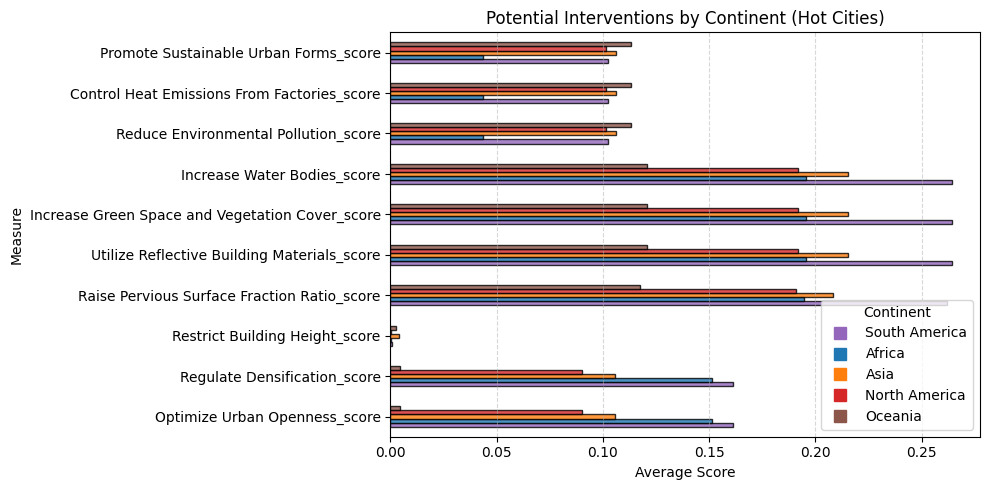

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume `continent_mean_hot` is your DataFrame:
#   continent_mean_hot:
#     Continent | Measure_A_score | Measure_B_score | Measure_C_score | …

# Your continent color palette
continent_palette = {
    'Africa':        '#1f77b4',
    'Asia':          '#ff7f0e',
    'Europe':        '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania':       '#8c564b'
}

# 1. Pivot the DataFrame so that measures become rows
df_plot = (
    continent_mean_hot
      .set_index('Continent')
      .transpose()
    # Now each row is a measure, each column is a continent
)

# 2. Create a horizontal grouped bar chart
fig, ax = plt.subplots(figsize=(10, len(df_plot) * 0.5))

# Build a list of colors matching the continent order
colors = [continent_palette.get(cont, '#333333') for cont in df_plot.columns]

df_plot.plot(
    kind='barh',
    ax=ax,
    color=colors,
    edgecolor='black',
    alpha=0.8
)

# 3. Labels and title
ax.set_xlabel('Average Score')
ax.set_ylabel('Measure')
ax.set_title('Potential Interventions by Continent (Hot Cities)')
ax.grid(axis='x', linestyle='--', alpha=0.5)

# 4. Build a custom legend for the continent colors
handles = [
    plt.Line2D([0], [0],
               marker='s',
               color=continent_palette[cont],
               linestyle='None',
               markersize=8,
               label=cont)
    for cont in df_plot.columns
]
ax.legend(handles=handles, title='Continent', loc='lower right')

plt.tight_layout()
plt.show()


Number of hot cities: 217


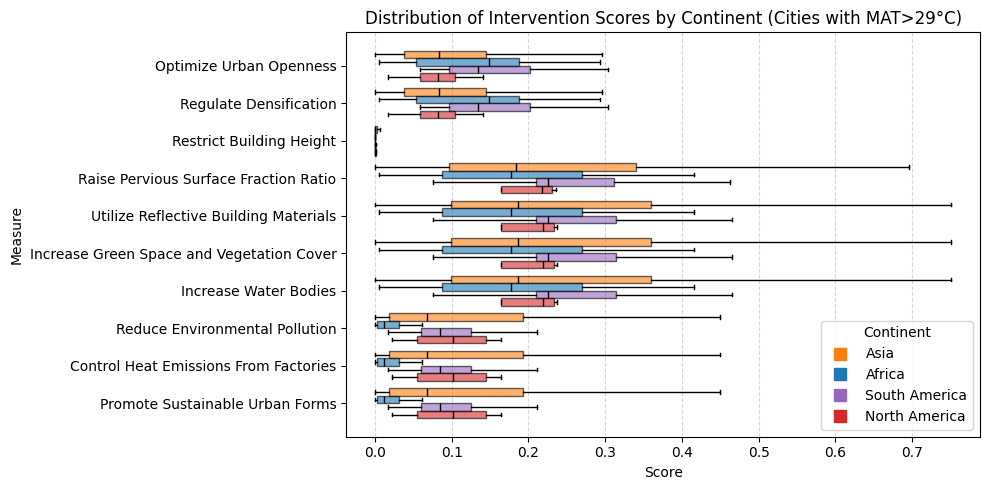

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 0) Load your merged data (replace with your actual file/path) ---
merged_data = pd.read_csv('output/merged_data.csv')  # must contain City, Continent, Mean_2071_2100, LCZ_* cols

# --- 1) Filter to the hottest cities first ---
hot_cities = merged_data[merged_data["Mean_2071_2100"] > 29].copy()
print(f"Number of hot cities: {len(hot_cities)}")

# --- 2) Read & clean the LCZ→measure mapping from Excel ---
mapping_df = (
    pd.read_excel("lcz_measures_mapping.xlsx", sheet_name="Sheet1", index_col=0)
      .fillna(0)
)
mapping_df.index = mapping_df.index.str.replace("LCZ ", "LCZ_")
mapping_df = mapping_df.astype(int)

# --- 3) Identify LCZ‑share columns in hot_cities ---
lcz_cols = [c for c in hot_cities.columns if c.startswith("LCZ_")]

# --- 4) Zero‑fill missing LCZ shares in the hot city data ---
hot_cities[lcz_cols] = hot_cities[lcz_cols].fillna(0)

# --- 5) Reindex mapping_df to match those LCZ columns ---
mapping_df = mapping_df.reindex(index=lcz_cols, fill_value=0)

# --- 6) Compute weighted scores for hot cities ---
weighted_measures = hot_cities[lcz_cols].dot(mapping_df)
weighted_measures = weighted_measures.add_suffix("_score")

# --- 7) Inject those scores into the hot_cities DataFrame ---
hot_cities[weighted_measures.columns] = weighted_measures

# --- 8) Prepare for plotting ---
score_cols = weighted_measures.columns.tolist()

# Convert to “long” form so each row is one city–measure score
long_df = hot_cities.melt(
    id_vars=['Continent'],
    value_vars=score_cols,
    var_name='Measure',
    value_name='Score'
)

# Strip the "_score" suffix for nicer labels
long_df['Measure'] = long_df['Measure'].str.replace('_score', '', regex=False)

measures   = long_df['Measure'].unique()
continents = long_df['Continent'].unique()
n_meas     = len(measures)
n_cont     = len(continents)

# --- 9) Define your continent color palette ---
continent_palette = {
    'Africa':         '#1f77b4',
    'Asia':           '#ff7f0e',
    'Europe':         '#2ca02c',
    'North America':  '#d62728',
    'South America':  '#9467bd',
    'Oceania':        '#8c564b'
}

# --- 10) Create the boxplot figure ---
fig, ax = plt.subplots(figsize=(10, n_meas * 0.5))

# width of each box group
width = 0.8 / n_cont
y_base = np.arange(n_meas)

for j, cont in enumerate(continents):
    # gather scores for this continent & each measure
    data = [
        long_df.loc[
            (long_df['Continent'] == cont) & (long_df['Measure'] == m),
            'Score'
        ].dropna().values
        for m in measures
    ]
    # compute positions for this continent’s boxes
    positions = y_base - 0.4 + j * width + width / 2
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=width,
        vert=False,
        patch_artist=True,
        manage_ticks=False,
        showfliers=False
    )
    # style the boxes
    for patch in bp['boxes']:
        patch.set_facecolor(continent_palette.get(cont, '#333333'))
        patch.set_alpha(0.6)
    # style the medians
    for median in bp['medians']:
        median.set_color('black')

# Y‑axis ticks & labels
ax.set_yticks(y_base)
ax.set_yticklabels(measures)
ax.invert_yaxis()

# Labels, title, grid
ax.set_xlabel('Score')
ax.set_ylabel('Measure')
ax.set_title('Distribution of Intervention Scores by Continent (Cities with MAT>29°C)')
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Custom legend
handles = [
    plt.Line2D(
        [0], [0],
        marker='s',
        color=continent_palette.get(cont, '#333333'),
        linestyle='None',
        markersize=8,
        label=cont
    )
    for cont in continents
]
ax.legend(handles=handles, title='Continent', loc='lower right')

plt.tight_layout()
plt.show()


In [62]:
import pandas as pd

# --- assume hot_cities already exists with columns City, Continent, and *_score ---

# 1) Melt into long form, dropping the "_score" suffix for readability
score_cols = [c for c in hot_cities.columns if c.endswith('_score')]
long = hot_cities.melt(
    id_vars=['City','Continent'],
    value_vars=score_cols,
    var_name='Measure',
    value_name='Score'
)
long['Measure'] = long['Measure'].str.replace('_score','', regex=False)

# 2) For each (Continent, Measure) find the row with the smallest Score
idx = long.groupby(['Continent','Measure'])['Score'].idxmax()
lowest_per = long.loc[idx].reset_index(drop=True)

print(lowest_per)


                       City      Continent  \
0                  Djibouti         Africa   
1                  Djibouti         Africa   
2                  Djibouti         Africa   
3                    Bamako         Africa   
4                  Djibouti         Africa   
5                  Djibouti         Africa   
6                  Djibouti         Africa   
7                    Bamako         Africa   
8                Al Gadarif         Africa   
9                  Djibouti         Africa   
10          Masqat (Muscat)           Asia   
11  Al Kuwayt (Kuwait City)           Asia   
12  Al Kuwayt (Kuwait City)           Asia   
13                Ahmadabad           Asia   
14          Masqat (Muscat)           Asia   
15                   Jiddah           Asia   
16          Masqat (Muscat)           Asia   
17                Ahmadabad           Asia   
18    Singapore Johor Bahru           Asia   
19  Al Kuwayt (Kuwait City)           Asia   
20             Villahermosa  North